<a href="https://colab.research.google.com/github/rahuls569/EVA8/blob/main/Assignment8/Assign_8_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Write a custom ResNet architecture for CIFAR10 that has the following architecture:
    1. PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
    2. Layer1 -
      1. X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
      2. R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 
      3. Add(X, R1)
    3. Layer 2 -
      1. Conv 3x3 [256k]
      2. MaxPooling2D
      3. BN
      4. ReLU
    4. Layer 3 -
      1. X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
      2. R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
      3. Add(X, R2)
    5. MaxPooling with Kernel Size 4
    6. FC Layer 
    7. SoftMax
2. Uses One Cycle Policy such that:
    1. Total Epochs = 24
    2. Max at Epoch = 5
    3. LRMIN = FIND
    4. LRMAX = FIND
    5. NO Annihilation
3. Uses this transform -RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
4. Batch size = 512
5. Target Accuracy: 90% (93.8% quadruple scores). 
6. NO score if your code is not modular. Your collab must be importing your GitHub package, and then just running the model. I should be able to find the custom_resnet.py model in your GitHub repo that you'd be training. 
7.Once done, proceed to answer the Assignment-Solution page. 

# Loading Model from git hub



In [1]:
!pip install torch torchvision
from __future__ import print_function

# Load modules/models from EVA course

!git clone https://github.com/rahuls569/Main_Repo -q --quiet
!mv Main_Repo/* .
!rm -rf Main_Repo


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -U git+https://github.com/albu/albumentations -q --quiet

  Preparing metadata (setup.py) ... done


# CIFAR DATASET

In [3]:
from main import *

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [4]:
cifar10_dataset = CIFAR10Dataset('./data')
classes = cifar10_dataset.get_classes()
exp_data=cifar10_dataset.get_data()
print(classes)
exp=cifar10_dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Data Statistics

In [5]:
!pip install torch_lr_finder
from utils import *
data_stats = DataStatistics(exp_data)
data_stats.print_statistics()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


# Plotting images

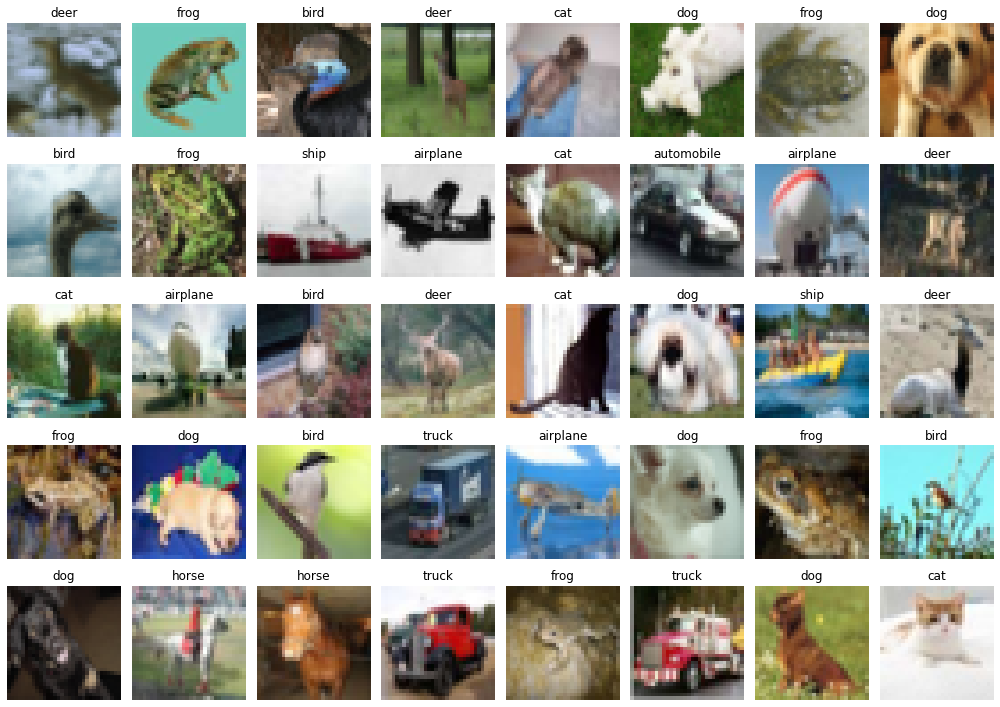

In [6]:
viz_data(cifar10_dataset, cols=8, rows=5)

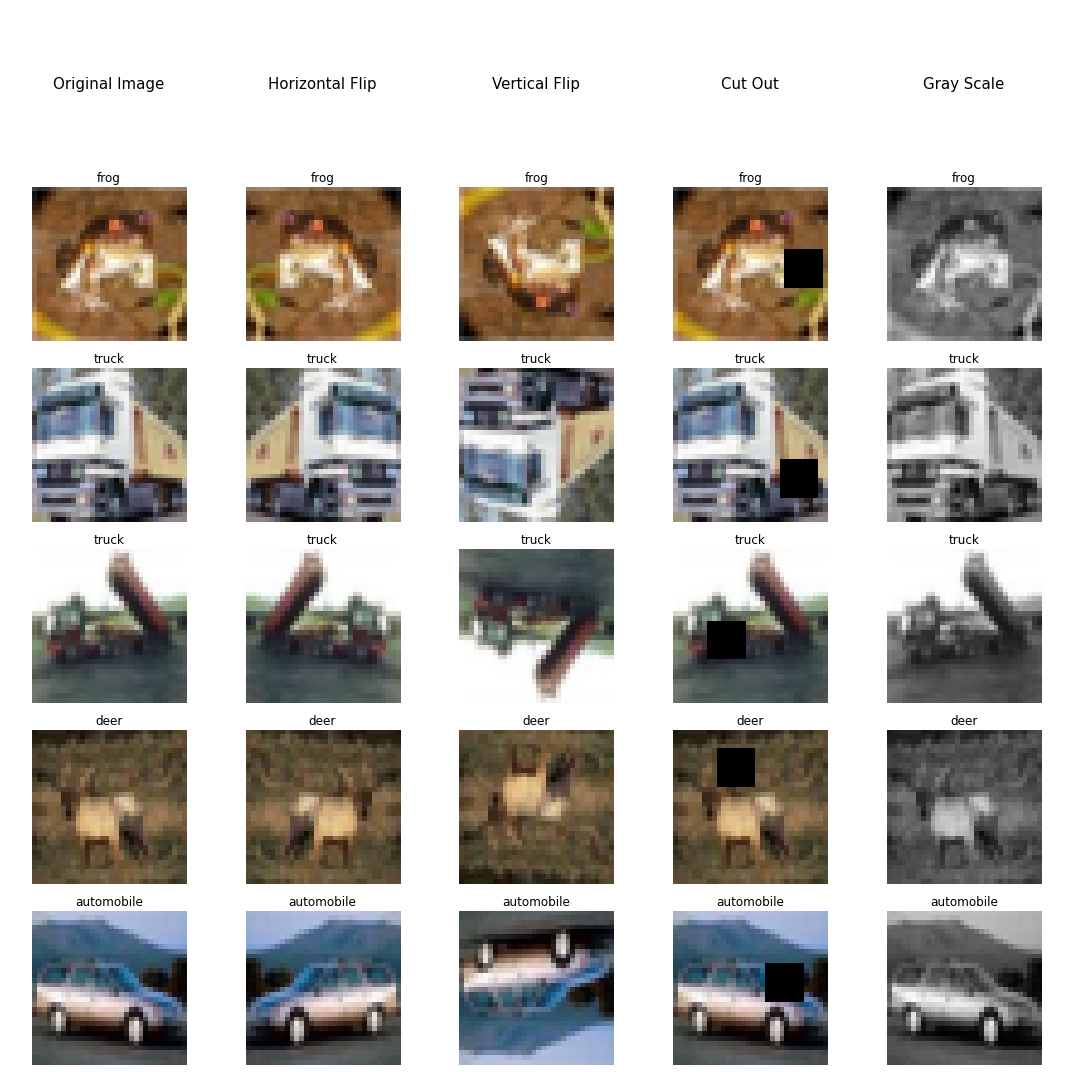

In [7]:
show_images(cifar10_dataset, {
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, 
                               min_width=8, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=512

CUDA Available: True


# Loading train and test data with transforms and loader functions

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


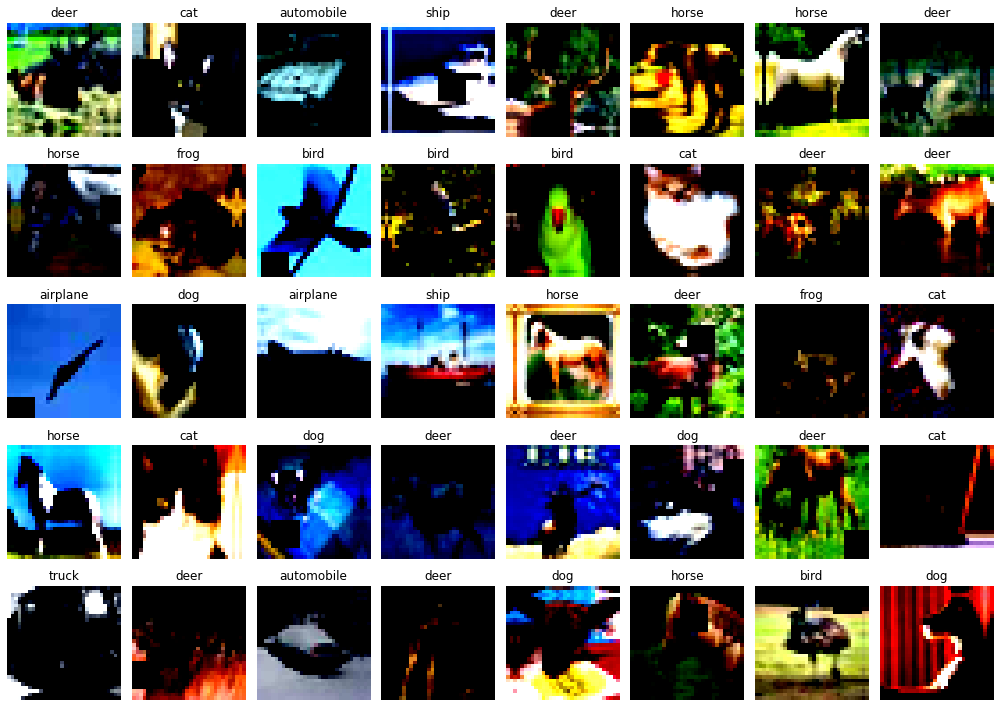

In [10]:


# Visualize training data
tain_loader_image(train_loader, classes, cols=8, rows=5)

In [11]:
from models.CustomResNet import *
import torch

# Load CUSTOM RESNET Model

In [12]:
# Loading ResNet18 Model
net = CustomResNet()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Torch Summary

In [13]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
    

# LR for One Cycle Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.74E-02


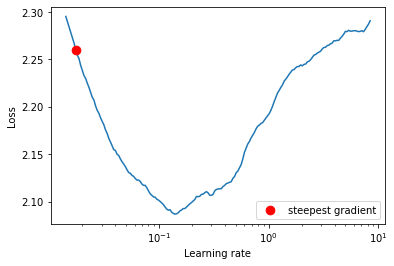

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.017426333860096503)

In [14]:
import copy
net_exp= copy.deepcopy(net)

optimizer = torch.optim.SGD(net_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() 

In [15]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.13987131026472382


In [16]:
ler_rate

0.13987131026472382

# Training and Testing

In [17]:
net = net.to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.07, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.07,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.208,
                                                div_factor=25,
                                                three_phase=False, 
                                                final_div_factor=100,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader, test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.0028000000000000004)


Batch_id=97 Loss=2.10311 Accuracy=35.07%: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 2.0278, Accuracy: 4303/10000 (43.03%)

EPOCH: 2 (LR: 0.016289111376931526)


Batch_id=97 Loss=1.97383 Accuracy=48.31%: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 1.9714, Accuracy: 4862/10000 (48.62%)

EPOCH: 3 (LR: 0.029778222753863052)


Batch_id=97 Loss=1.87217 Accuracy=58.67%: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 1.8297, Accuracy: 6300/10000 (63.00%)

EPOCH: 4 (LR: 0.043267334130794574)


Batch_id=97 Loss=1.81944 Accuracy=63.95%: 100%|██████████| 98/98 [00:26<00:00,  3.67it/s]



Test set: Average loss: 1.8182, Accuracy: 6410/10000 (64.10%)

EPOCH: 5 (LR: 0.0567564455077261)


Batch_id=97 Loss=1.78524 Accuracy=67.37%: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 1.8066, Accuracy: 6517/10000 (65.17%)

EPOCH: 6 (LR: 0.06993298737373738)


Batch_id=97 Loss=1.74001 Accuracy=71.99%: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 1.7352, Accuracy: 7252/10000 (72.52%)

EPOCH: 7 (LR: 0.06625180050505051)


Batch_id=97 Loss=1.70615 Accuracy=75.36%: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 1.7034, Accuracy: 7576/10000 (75.76%)

EPOCH: 8 (LR: 0.06257061363636364)


Batch_id=97 Loss=1.68079 Accuracy=77.92%: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]



Test set: Average loss: 1.6990, Accuracy: 7619/10000 (76.19%)

EPOCH: 9 (LR: 0.05888942676767677)


Batch_id=97 Loss=1.67079 Accuracy=78.98%: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]



Test set: Average loss: 1.6791, Accuracy: 7819/10000 (78.19%)

EPOCH: 10 (LR: 0.0552082398989899)


Batch_id=97 Loss=1.65795 Accuracy=80.21%: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]



Test set: Average loss: 1.6704, Accuracy: 7892/10000 (78.92%)

EPOCH: 11 (LR: 0.051527053030303034)


Batch_id=97 Loss=1.64497 Accuracy=81.53%: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 1.6411, Accuracy: 8210/10000 (82.10%)

EPOCH: 12 (LR: 0.047845866161616166)


Batch_id=97 Loss=1.63327 Accuracy=82.76%: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 1.6401, Accuracy: 8206/10000 (82.06%)

EPOCH: 13 (LR: 0.0441646792929293)


Batch_id=97 Loss=1.62314 Accuracy=83.79%: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 1.6346, Accuracy: 8261/10000 (82.61%)

EPOCH: 14 (LR: 0.04048349242424243)


Batch_id=97 Loss=1.61327 Accuracy=84.77%: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]



Test set: Average loss: 1.6389, Accuracy: 8230/10000 (82.30%)

EPOCH: 15 (LR: 0.03680230555555555)


Batch_id=97 Loss=1.60585 Accuracy=85.49%: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]



Test set: Average loss: 1.6235, Accuracy: 8377/10000 (83.77%)

EPOCH: 16 (LR: 0.033121118686868685)


Batch_id=97 Loss=1.59922 Accuracy=86.17%: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]



Test set: Average loss: 1.6153, Accuracy: 8456/10000 (84.56%)

EPOCH: 17 (LR: 0.029439931818181823)


Batch_id=97 Loss=1.59164 Accuracy=86.97%: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]



Test set: Average loss: 1.6075, Accuracy: 8546/10000 (85.46%)

EPOCH: 18 (LR: 0.025758744949494948)


Batch_id=97 Loss=1.58210 Accuracy=87.92%: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 1.6040, Accuracy: 8572/10000 (85.72%)

EPOCH: 19 (LR: 0.022077558080808087)


Batch_id=97 Loss=1.57785 Accuracy=88.32%: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 1.6023, Accuracy: 8596/10000 (85.96%)

EPOCH: 20 (LR: 0.01839637121212121)


Batch_id=97 Loss=1.57284 Accuracy=88.84%: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 1.5960, Accuracy: 8659/10000 (86.59%)

EPOCH: 21 (LR: 0.01471518434343435)


Batch_id=97 Loss=1.56274 Accuracy=89.86%: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]



Test set: Average loss: 1.5869, Accuracy: 8741/10000 (87.41%)

EPOCH: 22 (LR: 0.011033997474747474)


Batch_id=97 Loss=1.55621 Accuracy=90.52%: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 1.5816, Accuracy: 8808/10000 (88.08%)

EPOCH: 23 (LR: 0.007352810606060606)


Batch_id=97 Loss=1.55077 Accuracy=91.02%: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]



Test set: Average loss: 1.5795, Accuracy: 8825/10000 (88.25%)

EPOCH: 24 (LR: 0.0036716237373737304)


Batch_id=97 Loss=1.54562 Accuracy=91.63%: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 1.5743, Accuracy: 8876/10000 (88.76%)



#GRAPH LOSS and ACCURACY

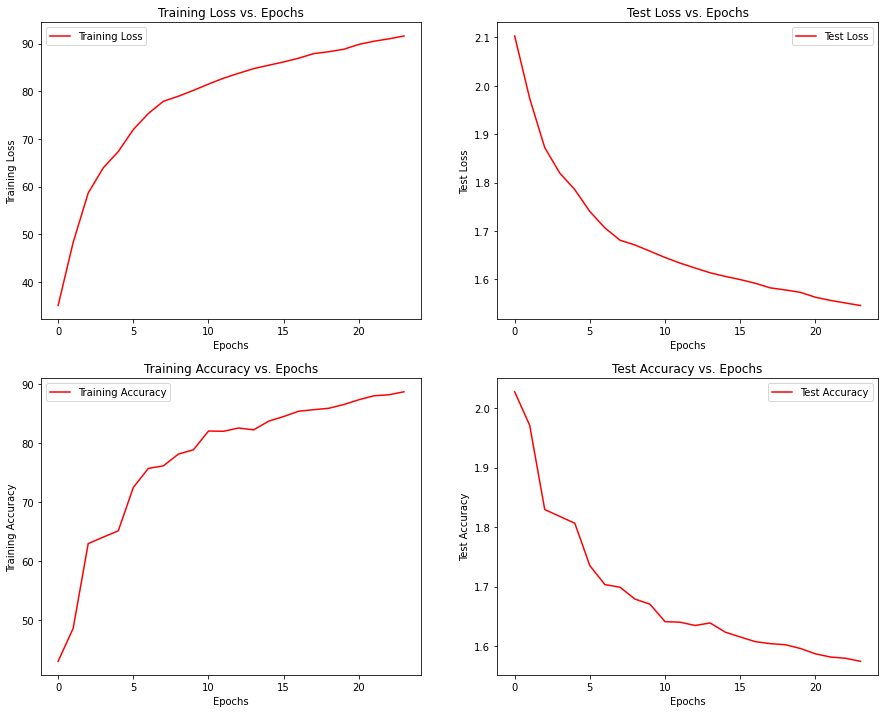

In [18]:
Graph_loss_accuracy_one_cycle(history)

In [19]:
ler_rate / (25 * 50)

0.00011189704821177905